In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import os

# Function to extract addition problems and their results
def extract_addition_problems(file_path, n_digits, m_digits):
    """
    Extracts n-digit by m-digit addition problems and the LLM's predictions from the file.
    Excludes specific problems when both n_digits and m_digits are 3.

    Args:
        file_path (str): The path to the results file.
        n_digits (int): The number of digits in the first term.
        m_digits (int): The number of digits in the second term.

    Returns:
        List of tuples: Each tuple contains (term1, term2, predicted_result, correct_result)
    """
    exclude_problems = [(100, 200, 300), (520, 890, 1410), (100, 100, 200)]
    problems = []

    try:
        with open(file_path, 'rb') as file:
            lines = pickle.load(file)
            for line in lines:
                # Ensure that 'line' is treated as a string if it comes in list form
                if isinstance(line, str):
                    # Match addition problems using regex, e.g., '123 + 45 = 168'
                    match = re.match(r'(\d+) \+ (\d+) = (\d+)', line.strip())
                    if match:
                        term1, term2, predicted_result = match.groups()
                        term1, term2, predicted_result = int(term1), int(term2), int(predicted_result)

                        # Check if the term lengths match n_digits and m_digits
                        if len(str(term1)) == n_digits and len(str(term2)) == m_digits:
                            # Exclude specific problems when both n_digits and m_digits are 3
                            if n_digits == 3 and m_digits == 3 and (term1, term2, predicted_result) in exclude_problems:
                                continue
                            correct_result = term1 + term2
                            problems.append((term1, term2, predicted_result, correct_result))
    except FileNotFoundError:
        print(f"File not found: {file_path}")
    
    return problems

# Loss function (Mean Squared Error)
def mse_loss(problems):
    """
    Calculates the MSE between the predicted results and the correct results.

    Args:
        problems (list): List of tuples (term1, term2, predicted_result, correct_result)

    Returns:
        float: Mean squared error
    """
    squared_errors = [(pred - correct) ** 2 for _, _, pred, correct in problems]
    return np.mean(squared_errors)

if __name__ == "__main__":
    temperatures = np.arange(0, 2.1, 0.1)  # Temperatures from 0.0 to 2.0

    # Loop over temperatures
    for k in temperatures:
        X, Y, Z = [], [], []  # Reset X, Y, Z for each temperature
        
        # Loop over all digit combinations from 1-digit to 8-digit
        for i in range(1, 9):  # First term (1-digit to 8-digit)
            for j in range(1, 9):  # Second term (1-digit to 8-digit)
                file_path = f"{i}_results/{i}_by_{j}_results/{i}_by_{j}_at_{k:.1f}_results.pkl"
                rfile_path = f"{i}_results/{j}_by_{i}_results/{j}_by_{i}_at_{k:.1f}_results.pkl"

                # Extract i-digit by j-digit problems
                problems = extract_addition_problems(file_path, i, j)
                problems_reverse = extract_addition_problems(rfile_path, j, i)

                # Calculate MSE loss for both normal and reverse problems
                mse = mse_loss(problems) if problems else 0
                mse_reverse = mse_loss(problems_reverse) if problems_reverse else 0

                # Calculate the average MSE
                avg_mse = (mse + mse_reverse) / 2

                # Append the average MSE, i (first term digits), j (second term digits) to the arrays
                X.append(i)
                Y.append(j)
                Z.append(avg_mse)

        # After collecting MSE values for all i-by-j combinations at this temperature, plot the landscape
        if X and Y and Z:
            X_grid, Y_grid = np.meshgrid(np.arange(1, 9), np.arange(1, 9))  # Full 8x8 grid
            Z_grid = np.array(Z).reshape(X_grid.shape)

            # Determine output directory for the current temperature
            output_dir = f"temp_{k:.1f}_loss_landscape"
            os.makedirs(output_dir, exist_ok=True)

            # Plot and save the loss landscape for this temperature
            plot_loss_landscape(X_grid, Y_grid, Z_grid, 8, 8, k, output_dir)



FileNotFoundError: [Errno 2] No such file or directory: '1_results/1_by_1_results/1_by_1_at_0.0_results.pkl'

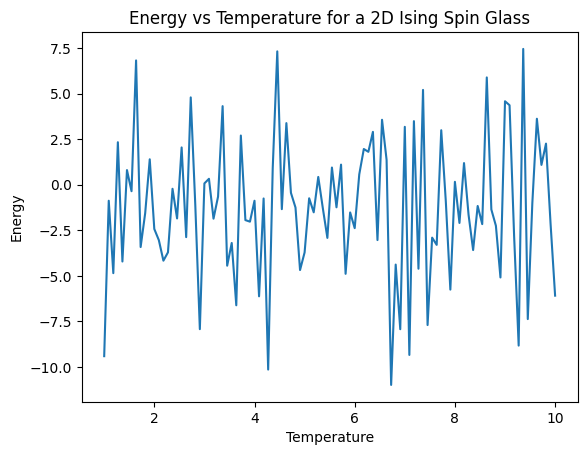

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Initialize a 2D spin glass model
L = 4  # Lattice size (4x4 grid)
spins = np.random.choice([-1, 1], size=(L, L))  # Random initial configuration
J = np.random.randn(L, L)  # Random interaction strengths (normally distributed)

# Define the Hamiltonian (energy function)
def compute_energy(spins, J):
    energy = 0
    for i in range(L):
        for j in range(L):
            # Sum nearest-neighbor interactions (periodic boundary conditions)
            energy -= J[i, j] * spins[i, j] * (spins[(i + 1) % L, j] + spins[i, (j + 1) % L])
    return energy

# Metropolis algorithm (Monte Carlo simulation)
def metropolis_step(spins, J, T):
    i, j = np.random.randint(0, L, size=2)  # Pick a random spin
    dE = 2 * spins[i, j] * (J[i, j] * (spins[(i + 1) % L, j] + spins[i, (j + 1) % L]))
    if dE < 0 or random.random() < np.exp(-dE / T):  # Metropolis criterion
        spins[i, j] *= -1  # Flip the spin
    return spins

# Simulate the energy landscape at different temperatures
temperatures = np.linspace(1, 10, 100)
energies = []

for T in temperatures:
    spins = np.random.choice([-1, 1], size=(L, L))  # Reset configuration
    for _ in range(1000):  # Monte Carlo steps
        spins = metropolis_step(spins, J, T)
    energy = compute_energy(spins, J)
    energies.append(energy)

# Plot the energy as a function of temperature
plt.plot(temperatures, energies)
plt.xlabel('Temperature')
plt.ylabel('Energy')
plt.title('Energy vs Temperature for a 2D Spin Glass')
plt.show()
